In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from bepsf.image import *
from bepsf.psfmodel import *
from bepsf.utils import *
from bepsf.infer import *

In [2]:
import matplotlib.pyplot as plt
import corner
import pandas as pd
from arviz import plot_trace
from jax.config import config
config.update('jax_enable_x64', True)

In [3]:
plt.rcParams['figure.dpi'] = 100

## define image grid

In [4]:
Npix = 30*3
super_factor = 3.

In [5]:
image_obs = PixelImage(Npix, Npix)
image_super = PixelImage(Npix, Npix, dx=1./super_factor, dy=1./super_factor)

In [6]:
print (image_obs.shape, image_super.shape)

(90, 90) (270, 270)


## simulate an image with Gaussian sources

In [7]:
Nsource = 10
np.random.seed(124)
norms = np.ones(Nsource)
norms = 10**np.random.rand(Nsource)
xcenters = np.random.rand(Nsource) * image_super.xmax
ycenters = np.random.rand(Nsource) * image_super.ymax
sigma = 1.

In [8]:
image_super.Z = simulate_gaussian_sources(image_super, norms, xcenters, ycenters, sigma)
Zobs = super_to_obs(image_super.Z, image_obs)

In [9]:
np.random.seed(123)
sigmaerr = 2e-3
image_err = np.ones(image_obs.shape) * sigmaerr
Zerr = image_err * np.random.randn(*image_obs.shape)
image_obs.Z = Zobs + Zerr

## image mask

In [10]:
image_obs.define_mask(xcenters, ycenters, 7.)
image_super.define_mask(xcenters, ycenters, 7.)

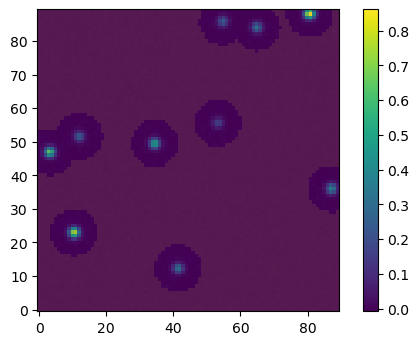

In [11]:
plt.imshow(image_obs.Z)
plt.colorbar()
plt.imshow(image_obs.mask, alpha=0.1, origin='lower');

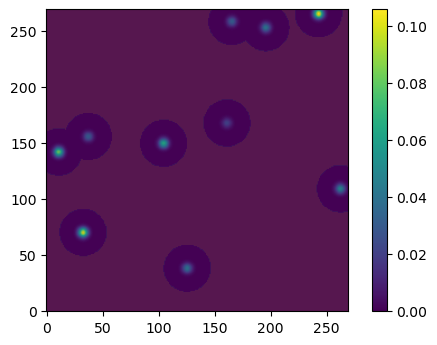

In [12]:
plt.imshow(image_super.Z)
plt.colorbar()
plt.imshow(image_super.mask, alpha=0.1, origin='lower');

## initial guess for positions and fluxes

In [13]:
use_photocenter = True
xcenters_guess, ycenters_guess, fluxes_guess = np.array([]), np.array([]), np.array([])
for x,y in zip(xcenters, ycenters):
    idx_ap = image_obs.aperture_flux(x, y, 3.)
    flux_ap = image_obs.Z[idx_ap]
    x_ap = image_obs.X[idx_ap]
    y_ap = image_obs.Y[idx_ap]
    if use_photocenter:
        xcenters_guess = np.append(xcenters_guess, np.average(x_ap, weights=flux_ap))
        ycenters_guess = np.append(ycenters_guess, np.average(y_ap, weights=flux_ap))
    else:
        xcenters_guess = np.append(xcenters_guess, x)
        ycenters_guess = np.append(ycenters_guess, y)
    fluxes_guess = np.append(fluxes_guess, np.sum(flux_ap))   
lnfluxes_guess = np.log(fluxes_guess)

idx_anchor = np.argmax(lnfluxes_guess)
print ("# anchor source: %d."%idx_anchor)

# anchor source: 9.


### make sure that the anchor is an isolated source and is not around the edge

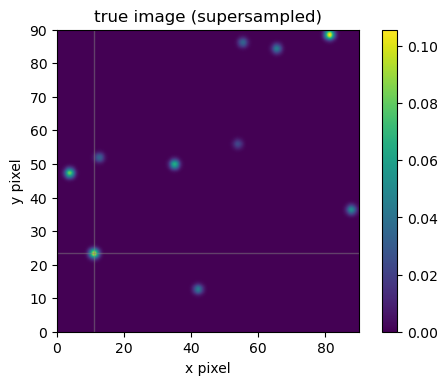

In [18]:
idx_anchor = 1
plot_image(image_super, title='true image (supersampled)',
          xcenters=xcenters[idx_anchor:idx_anchor+1],
          ycenters=ycenters[idx_anchor:idx_anchor+1])

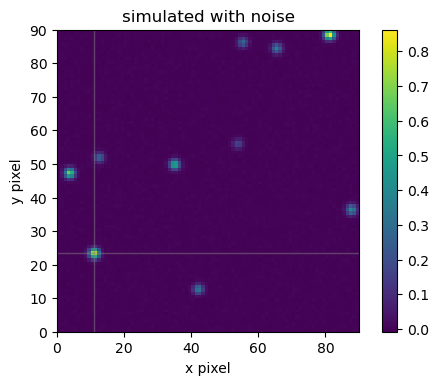

In [19]:
plot_image(image_obs, title='simulated with noise',
          xcenters=xcenters[idx_anchor:idx_anchor+1],
          ycenters=ycenters[idx_anchor:idx_anchor+1])

In [23]:
# perturb initial guess
np.random.seed(321)
perturb = np.random.randn(Nsource)*0.
perturb[idx_anchor] = 0.
xcenters_guess += perturb
ycenters_guess -= perturb
print (perturb)

[ 0.  0.  0. -0. -0. -0. -0. -0. -0.  0.]


In [24]:
xcenters_guess - xcenters

array([ 0.16255957, -0.00605026,  0.03987884, -0.90836575, -1.13947005,
       -0.61561503, -1.33292705, -0.81337577, -0.13720527,  1.58643828])

## define grid PSF model

In [25]:
xext, yext = 7., 7.
dx, dy = 1./3., 1./3.
gridpsf = GridPSFModel(xext, yext, dx, dy)

PSF grid shape: (21, 21)
x centers: [-3.33333333 -3.         -2.66666667 -2.33333333 -2.         -1.66666667
 -1.33333333 -1.         -0.66666667 -0.33333333  0.          0.33333333
  0.66666667  1.          1.33333333  1.66666667  2.          2.33333333
  2.66666667  3.          3.33333333]
y centers: [-3.33333333 -3.         -2.66666667 -2.33333333 -2.         -1.66666667
 -1.33333333 -1.         -0.66666667 -0.33333333  0.          0.33333333
  0.66666667  1.          1.33333333  1.66666667  2.          2.33333333
  2.66666667  3.          3.33333333]


In [26]:
%%time
res = optimize_flux_and_position(gridpsf, image_obs, image_err, image_super, 
                                 lnfluxes_guess, xcenters_guess, ycenters_guess, idx_anchor, 
                                 n_iter=10)

ScipyMinimizeInfo(fun_val=DeviceArray(-6099.82314403, dtype=float64), success=True, status=1, iter_num=25)

ScipyMinimizeInfo(fun_val=DeviceArray(-6099.82314404, dtype=float64), success=True, status=1, iter_num=1)

ScipyMinimizeInfo(fun_val=DeviceArray(-6099.82314404, dtype=float64), success=True, status=1, iter_num=1)

ScipyMinimizeInfo(fun_val=DeviceArray(-6099.82314404, dtype=float64), success=True, status=1, iter_num=1)

ScipyMinimizeInfo(fun_val=DeviceArray(-6099.82314404, dtype=float64), success=True, status=1, iter_num=1)

ScipyMinimizeInfo(fun_val=DeviceArray(-6099.82314404, dtype=float64), success=True, status=1, iter_num=1)

ScipyMinimizeInfo(fun_val=DeviceArray(-6099.82314404, dtype=float64), success=True, status=1, iter_num=1)

ScipyMinimizeInfo(fun_val=DeviceArray(-6099.82314404, dtype=float64), success=True, status=1, iter_num=1)

ScipyMinimizeInfo(fun_val=DeviceArray(-6099.82314404, dtype=float64), success=True, status=1, iter_num=1)

ScipyMinimizeInfo(fun_val=DeviceArra

In [27]:
popt, state = res

In [28]:
popt

{'lnamp': DeviceArray(-6.16453863, dtype=float64),
 'lnfluxes': DeviceArray([0.22976748, 1.7019983 , 1.30739467, 1.03754399, 0.87399852,
              0.61946516, 1.52496266, 0.89222664, 0.63073003, 1.78263027],            dtype=float64),
 'lnlenx': DeviceArray(0., dtype=float64),
 'lnleny': DeviceArray(0., dtype=float64),
 'xcenters': DeviceArray([53.90559952, 11.05912196, 35.05989595, 87.74025429,
              42.07501822, 12.61495037,  3.78290892, 65.50953658,
              55.3965284 , 81.24110888], dtype=float64),
 'ycenters': DeviceArray([56.03721868, 23.40657067, 49.98882013, 36.44256529,
              12.75270978, 51.99503527, 47.37477767, 84.46370018,
              86.3021102 , 88.59706655], dtype=float64)}

In [29]:
popt['fluxes'] = jnp.exp(popt['lnfluxes'])
popt = drop_anchor(popt, idx_anchor)

In [30]:
xdrop = np.r_[xcenters[:idx_anchor], xcenters[idx_anchor+1:]]
ydrop = np.r_[ycenters[:idx_anchor], ycenters[idx_anchor+1:]]
fdrop = np.r_[norms[:idx_anchor], norms[idx_anchor+1:]] / norms[idx_anchor]

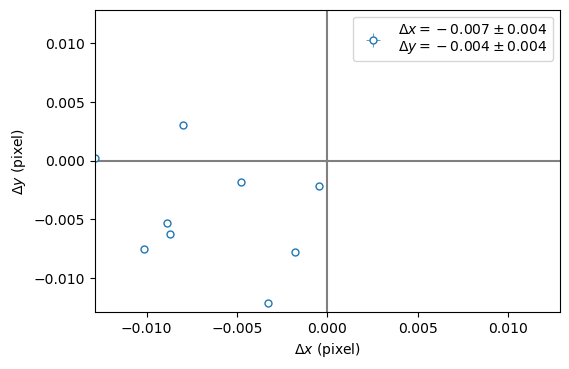

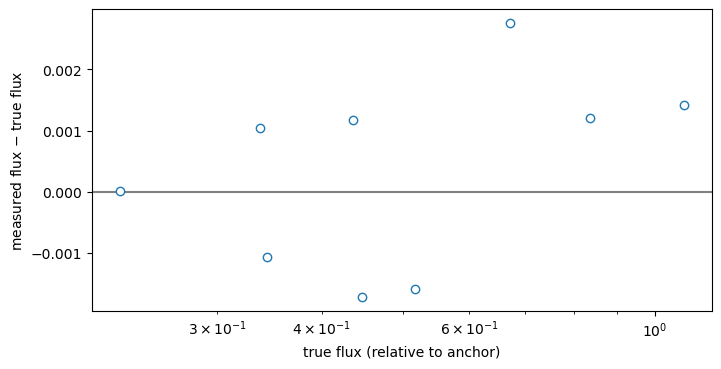

In [31]:
check_solution(popt['xcenters_drop'], popt['ycenters_drop'], np.exp(popt['lnfluxes_drop'])/fluxes_guess[idx_anchor],
               xdrop, ydrop, fdrop)

In [32]:
psf_pred, image_pred = gridpsf.gp_marginal(jnp.exp(popt['lnfluxes']), popt['xcenters'], popt['ycenters'], 
                            jnp.exp(popt['lnlenx']), jnp.exp(popt['lnleny']), jnp.exp(2*popt['lnamp']),
                            image_obs, image_err, image_super, return_pred=True)

In [33]:
meanpsf = psf_pred.reshape(*gridpsf.shape)
meanpsf /= np.sum(meanpsf)
truepsf = simulate_gaussian_sources(gridpsf, np.array([1.]), np.array([0.]), np.array([0.]), 1.)
truepsf /= np.sum(truepsf)

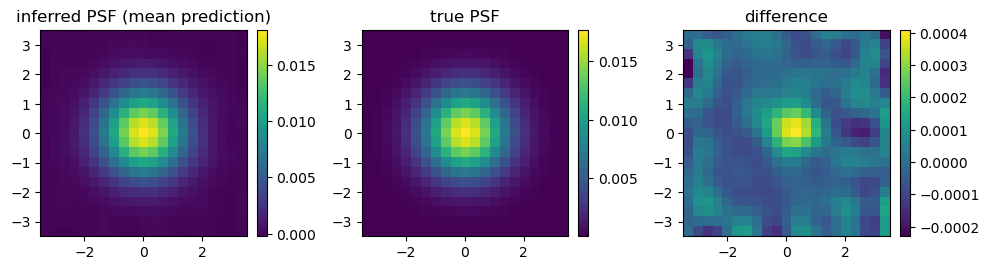

In [34]:
check_PSF_fit(gridpsf, meanpsf, truepsf)

/home/masuda/anaconda3/lib/python3.9/site-packages/bepsf-0.0.1-py3.9.egg/bepsf/utils.py:93: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[1].set_ylim(ylim)


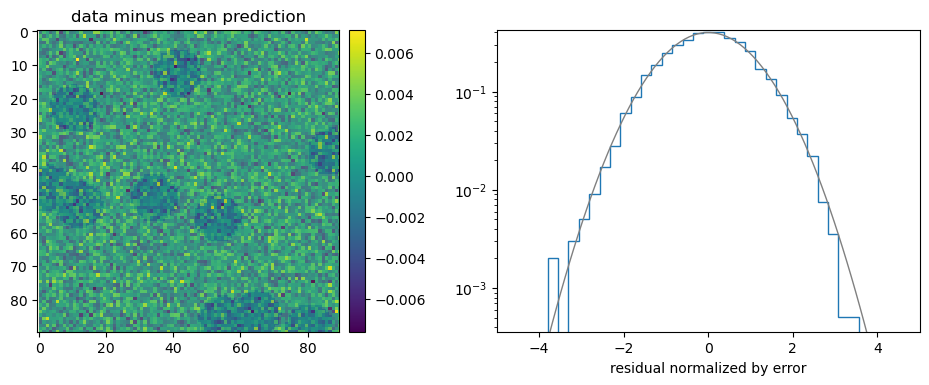

In [35]:
check_image_fit(image_obs, image_err, image_pred)

In [36]:
mcmc = run_hmc(gridpsf, image_obs, image_err, image_super, idx_anchor, popt)

  0%|                                                                                                              | 0/1000 [00:00<?, ?it/s]/home/masuda/anaconda3/lib/python3.9/site-packages/jax/_src/tree_util.py:200: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample: 100%|████████████████████████████████████████████████| 1000/1000 [07:08<00:00,  2.33it/s, 15 steps of size 2.81e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]      1.26      0.01      1.26      1.25      1.27    762.32      1.00
      f[1]      3.70      0.01      3.70      3.68      3.71    784.81      1.00
      f[2]      2.82      0.01      2.82      2.81      2.83    659.38      1.00
      f[3]      2.40      0.01      2.40      2.38      2.41    579.55      1.00
      f[4]      1.86      0.01      1.86      1.85      1.87    639.25      1.00
      f[5]      4.60      0.01      4.60      4.58      4.61    603.52      1.00
      f[6]      2.44      0.01      2.44      2.43      2.45    733.89      1.00
      f[7]      1.88      0.01      1.88      1.87      1.89    874.66      1.00
      f[8]      5.95      0.01      5.95      5.93      5.96    493.27      1.00
       lna     -5.77      0.13     -5.77     -5.98     -5.57    336.80      1.00
    lnlenx      0.27      0.04      0.27      0.19      0.33    517.90      1.00
    lnleny      0.26      0

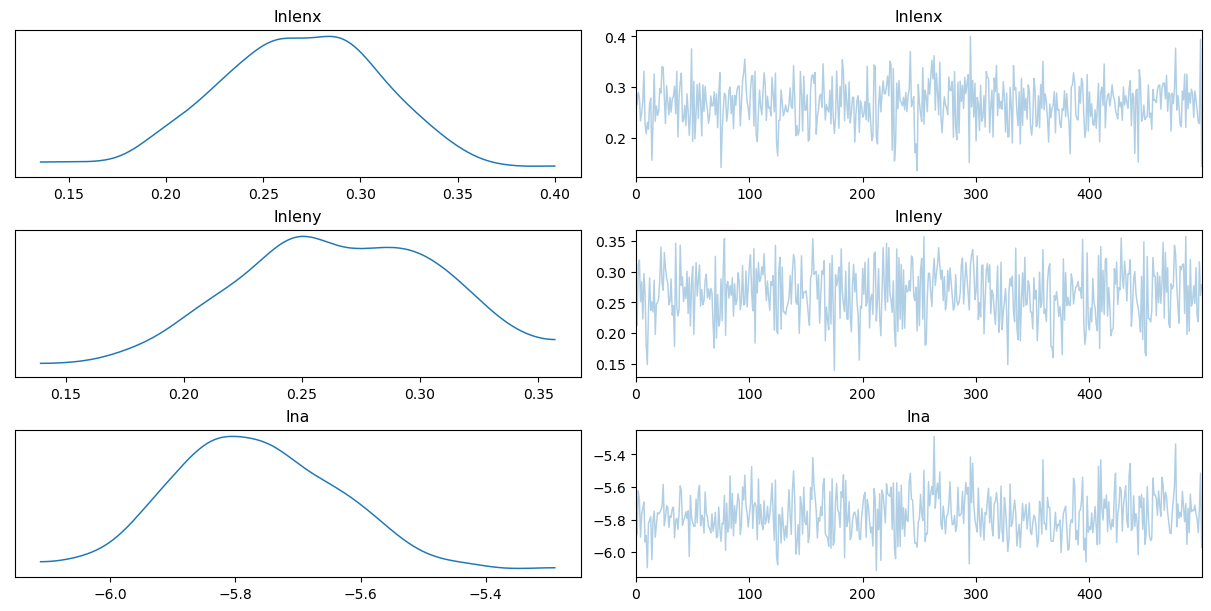

In [37]:
fig = plot_trace(mcmc, var_names=['lnlenx', 'lnleny', 'lna'])

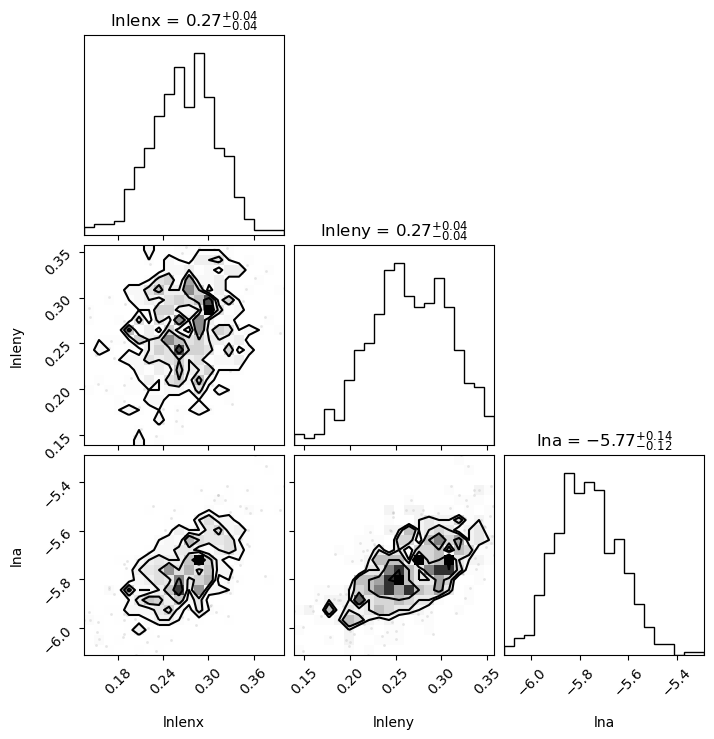

In [38]:
pnames = ["lnlenx", "lnleny", "lna"]
hyper = pd.DataFrame(data=dict(zip(pnames, [mcmc.get_samples()[k] for k in pnames])))
fig = corner.corner(hyper, labels=pnames, show_titles="%.2f")

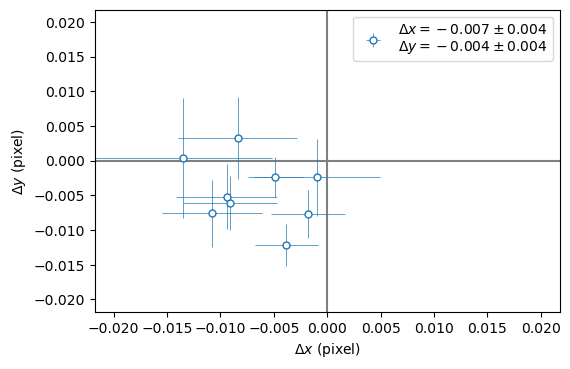

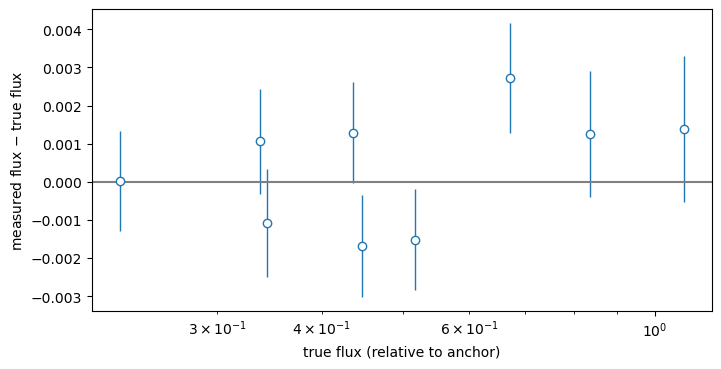

In [39]:
smp = mcmc.get_samples()
xmean, xstd = np.mean(smp['x'], axis=0), np.std(smp['x'], axis=0)
ymean, ystd = np.mean(smp['y'], axis=0), np.std(smp['y'], axis=0)
fmean, fstd = np.mean(smp['f'], axis=0), np.std(smp['f'], axis=0)
f_anchor = np.exp(lnfluxes_guess[idx_anchor])
fmean /= f_anchor
fstd /= f_anchor
check_solution(xmean, ymean, fmean, xdrop, ydrop, fdrop, xstd, ystd, fstd)